In [376]:
import qiskit as qk
from qiskit import *
import numpy as np
import random
import matplotlib as plt

In [377]:
def get_ground_state(num_qubits):

    q0 = [1., 0.] #ground state
    # return vector of size 2**num_qubits with all zeroes except first element which is 1
    elements = q0
    for i in range(0, num_qubits-1):
        elements = np.kron(elements, q0)
    #elements = np.zeros(2**num_qubits)
    #elements[0]=1
    return elements

In [378]:
def find_operator(total_qubits, gate_choice, target_qubits):
    #mandate that target_qubits has an array input!
    #Define X (NOT) Gate
    X = np.array([
    [0, 1],
    [1, 0]
    ])
    
    # Define H (Hadamard) gate:

    H = np.array([
        [1/np.sqrt(2), 1/np.sqrt(2)],
        [1/np.sqrt(2), -1/np.sqrt(2)]
    ])
    
    # Define projection operator |0><0|

    P0x0 = np.array([
    [1, 0],
    [0, 0]
    ])

    # Define projection operator |1><1|

    P1x1 = np.array([
    [0, 0],
    [0, 1]
    ])

    #2x2 identity
    I = np.identity(2)
    
    choice = np.identity(2)
    
    if(len(target_qubits)==1):
        #makes list of matrices!
        targets_li = np.linspace(I, I, total_qubits)
        
        #chooses where the unitary operator goes in the list of matrices, which will help with the creation
        #of the overall matrix operator
        if(gate_choice=="x" or gate_choice == "X"):
            targets_li[target_qubits[0]]=X
        elif(gate_choice=="h" or gate_choice == "H"):
            targets_li[target_qubits[0]]=H
        
        #ONCE YOU HAVE THE ARRAY OF IDENTITY MATRICES AND YOU SET THE CHOICE TO BE THE INDEX OF THE TARGET
        
        O = np.kron(targets_li[0], targets_li[1])
        
        for i in range(2, len(targets_li)):
            O = np.kron(O, targets_li[i])
        #print(O)
        return O
    
    elif(len(target_qubits)>1):
    #use projection operators to create CNOT!
        cx1 = np.linspace(I, I, total_qubits) 
        cx1[target_qubits[0]]=P0x0
        cx2 = np.linspace(I, I, total_qubits) 
        cx2[target_qubits[0]]=P1x1
        cx2[target_qubits[1]] = X
         
        O1 = np.kron(cx1[0], cx1[1])
        O2 = np.kron(cx2[0], cx2[1])
        
        for i in range(2, total_qubits):
            O1 = np.kron(O1, cx1[i])
            O2 = np.kron(O2, cx2[i])
        O_CNOT = O1+O2
        #print(O_CNOT)
        return O_CNOT
         
    
    #FOR TESTING PURPOSES
#psi = get_ground_state(2)
#print(psi)
#print("\n")
#psi = np.dot(psi, find_operator(2, "H", [0]))
#print("\n")
#psi = np.dot(psi, find_operator(2, "cx", [0,1]))
#print("\n")
#print(psi)

In [379]:
def run_program(initial_state, circuit, total_qubits):
    
    final_state = initial_state
    
    for i in range(0, len(circuit)):
        final_state = np.dot(final_state, find_operator(total_qubits, circuit[i]["gate"], circuit[i]["target"]))
    
    return final_state



In [380]:
def measure_all(state_vector):
    # choose element from state_vector using weighted random and return it's index
    
    #For example, return 00 for decimal index 0, or 11 for decimal index 3
    #fill the remaining values with zero
    
    #make empty string array
    bin_index = ["" for x in range(len(state_vector))]
    probabilities = [abs(state_vector[x])**2 for x in range(len(state_vector))]
    #print(probabilities)

    
    
    for i in range(0, len(bin_index)):
        #print(format(i, '00' + str(num_qubits) + 'b'))
        bin_index[i] = str(format(i, '00' + str(num_qubits) + 'b'))
    
    #comb_array = np.array([bin_index, state_vector])

    choice = random.choices(bin_index, probabilities)[0]
    
    #print(choice)
    return choice

In [381]:
def get_counts(state_vector, num_shots):
    # simply execute measure_all in a loop num_shots times and
    # return object with statistics in following form:
    #   {
    #      element_index: number_of_ocurrences,
    #      element_index: number_of_ocurrences,
    #      element_index: number_of_ocurrences,
    #      ...
    #   }
    # (only for elements which occoured - returned from measure_all)
    
    bin_index = ["" for x in range(len(state_vector))]
    
    for i in range(0, len(bin_index)):
        #print(format(i, '00' + str(num_qubits) + 'b'))
        bin_index[i] = str(format(i, '00' + str(num_qubits) + 'b'))
    
    values = {}
    
    for i in range(0, len(bin_index)):
        values[bin_index[i]]=0
    
    #setting all values to zero in the values dictionary
    
    for i in range(0, num_shots):
        values[measure_all(state_vector)] +=1

    for i in range(0, len(bin_index)):
        if(values[bin_index[i]]==0):
            del(values[bin_index[i]])
    
    return values

{'00': 508, '11': 492}


Text(0, 0.5, '# of Readings when Measured')

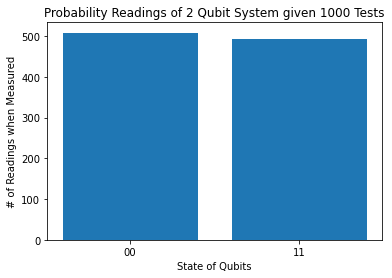

In [384]:
# Define program:

my_circuit = [
{ "gate": "h", "target": [0] }, 
{ "gate": "cx", "target": [0, 1] }
]

num_qubits = 2

# Create "quantum computer" with 2 qubits (this is actually just a vector :) )

my_qpu = get_ground_state(num_qubits)

# Run circuit

final_state = run_program(my_qpu, my_circuit, num_qubits)

# Read results

num_shots = 1000

counts = get_counts(final_state, num_shots)

print(counts)

x_list = list(counts.keys())
#print(x_list)
height_list = list(counts.values())
#print(height_list)

plt.pyplot.bar(x=x_list, height=height_list)
plt.pyplot.title("Probability Readings of 2 Qubit System given " + str(num_shots)+ " Tests")
plt.pyplot.xlabel("State of Qubits")
plt.pyplot.ylabel("# of Readings when Measured")